In [1]:
import pandas as pd
import os
folders = ["reviews/"]
files = [folder+f for folder in folders for f in os.listdir(folder)]

data = None
for f in files:
    print f
    df = pd.read_csv(f)
    df = df.set_index('business_id')
    df.columns = map(lambda c: f.split("/")[-2]+"_"+c, df.columns)
    data = df if data is None else df.join(data, rsuffix="_"+f[:3])

labels = pd.read_csv("business_labels.csv", index_col=0).dropna()

data = data.join(labels).dropna()
data.head(10)

reviews/reviews_features.csv


,reviews_no_previous_reviews,reviews_average_number_reviews_per_year,reviews_average_rating,reviews_no_years_success,reviews_last_year_success,suc
business_id,,,,,,
--9QQLMTbFzLJ_oT-ON3Xw,10,2.000000,3.400000,0,0,0.0
--ab39IjZR_xUf81WyTyHg,10,2.000000,4.200000,1,0,0.0
-0Sgh0QlUKVsWosCWJzGqQ,28,4.666667,2.285714,0,0,0.0
-2A9emZwBK8zYHPnAmM0hw,5,2.500000,2.200000,0,0,0.0
-2MFmbCTycnU4uPJ7jXfcA,2,1.000000,5.000000,0,0,1.0
-2X9U7v-Avoib-ki0y85bA,37,6.166667,4.594595,4,1,1.0
-4g68Hwm892_KPUuW5g1_Q,40,5.714286,2.675000,0,0,0.0
-4kOf3wcZp5bvxORgsW1gA,10,2.000000,3.500000,0,0,0.0
-82Z0wTA-nOCLUVD4XXIBA,30,3.000000,3.166667,1,0,0.0


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

X = data.drop('suc', 1).values
y = data['suc'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
probabilities = np.asarray([t[1] for t in clf.predict_proba(X_test)])
preds = np.asarray([1 if t>0.5 else 0 for t in probabilities])

print "Accuracy:", len(filter(lambda t: t[0]==t[1], zip(preds, y_test)))/float(len(y_test))
print(classification_report(y_test, preds, target_names="Bad Good".split()))
print "AUC ROC:", roc_auc_score(y_test, probabilities)

Accuracy: 0.750873108265
             precision    recall  f1-score   support

        Bad       0.82      0.85      0.83       636
       Good       0.52      0.47      0.50       223

avg / total       0.74      0.75      0.75       859

AUC ROC: 0.6767634035592407


In [4]:
from sklearn.ensemble import RandomForestClassifier
clfrf = RandomForestClassifier(n_estimators=30, min_samples_split=20, min_samples_leaf=10, 
                             class_weight=dict(zip(range(2), [0.2, 0.8])))
clfrf.fit(X_train, y_train)
prob_random_forest = np.asarray([t[1] for t in clfrf.predict_proba(X_test)])
preds = np.asarray([1 if t>0.5 else 0 for t in prob_random_forest])

print "Accuracy:", len(filter(lambda t: t[0]==t[1], zip(preds, y_test)))/float(len(y_test))
print(classification_report(y_test, preds, target_names="Bad Good".split()))
print "AUC ROC:", roc_auc_score(y_test, prob_random_forest)

Accuracy: 0.753201396973
             precision    recall  f1-score   support

        Bad       0.88      0.78      0.82       636
       Good       0.52      0.69      0.59       223

avg / total       0.78      0.75      0.76       859

AUC ROC: 0.825711425106467


/Users/vigneshwar/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
probabilities = np.asarray([t[1] for t in clf.predict_proba(X_test)])
preds = np.asarray([1 if t>0.5 else 0 for t in probabilities])

print "Accuracy:", len(filter(lambda t: t[0]==t[1], zip(preds, y_test)))/float(len(y_test))
print(classification_report(y_test, preds, target_names="Bad Good".split()))
print "AUC ROC:", roc_auc_score(y_test, probabilities)

Accuracy: 0.782305005821
             precision    recall  f1-score   support

        Bad       0.82      0.91      0.86       636
       Good       0.62      0.41      0.50       223

avg / total       0.77      0.78      0.77       859

AUC ROC: 0.7914833460247623


In [6]:
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score
import random

def get_best_cut(y_test, probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    
    return [(thresh, precision_score(y_test, [1 if p>thresh else 0 for p in probabilities], average="weighted"))
                for thresh in random.sample(thresholds, 50)]

scores = get_best_cut(y_test, probabilities)
best_cut, fscore = max(scores, key=lambda t: t[1])

preds = np.asarray([1 if t>best_cut else 0 for t in probabilities])

print "Accuracy:", len(filter(lambda t: t[0]==t[1], zip(preds, y_test)))/float(len(y_test))
print(classification_report(y_test, preds, target_names="Bad Good".split()))

Accuracy: 0.597206053551
             precision    recall  f1-score   support

        Bad       0.93      0.49      0.64       636
       Good       0.38      0.90      0.54       223

avg / total       0.79      0.60      0.62       859



/Users/vigneshwar/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
from sklearn.ensemble import GradientBoostingClassifier

clfgb = GradientBoostingClassifier()
clfgb.fit(X_train, y_train)
prob_gradient_boosting = np.asarray([t[1] for t in clfgb.predict_proba(X_test)])
preds = np.asarray([1 if t>0.5 else 0 for t in prob_gradient_boosting])

print "Accuracy:", len(filter(lambda t: t[0]==t[1], zip(preds, y_test)))/float(len(y_test))
print(classification_report(y_test, preds, target_names="Bad Good".split()))
print "AUC ROC:", roc_auc_score(y_test, prob_gradient_boosting)

Accuracy: 0.80908032596
             precision    recall  f1-score   support

        Bad       0.83      0.93      0.88       636
       Good       0.70      0.47      0.56       223

avg / total       0.80      0.81      0.80       859

AUC ROC: 0.8182199565671094


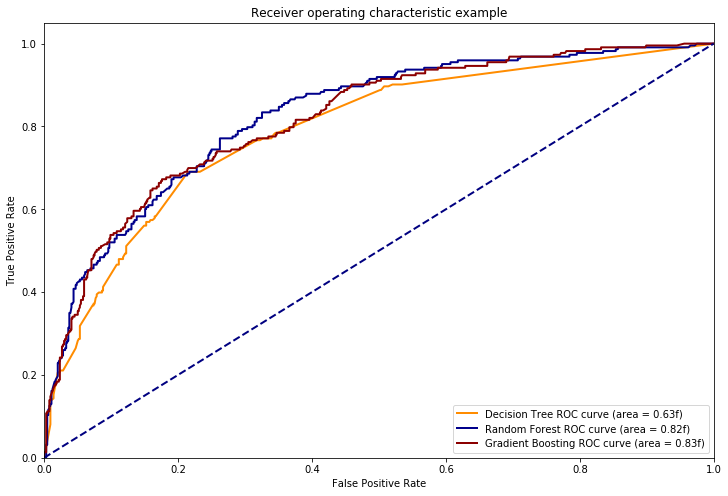

In [9]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))

fprdt, tprdt, thresholds = roc_curve(y_test, probabilities)
fprrf, tprrf, thresholds = roc_curve(y_test, prob_random_forest)
fprgb, tprgb, thresholds = roc_curve(y_test, prob_gradient_boosting)

lw = 2
plt.plot(fprdt, tprdt, color='darkorange',
         lw=lw, label='Decision Tree ROC curve (area = 0.63f)')
plt.plot(fprrf, tprrf, color='darkblue',
         lw=lw, label='Random Forest ROC curve (area = 0.82f)')
plt.plot(fprgb, tprgb, color='darkred',
         lw=lw, label='Gradient Boosting ROC curve (area = 0.83f)')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()